# Laboratorio 11 - Entrenando Redes Neuronales

**Este notebook está basado en el libro Hands-On Machine Learning with scikit-learn and Tensorflow de Aurélien Géron**

Anteriormente se vio redes neuronales artificales y su entrenamiento, pero de una manera vaga.  Vimos redes neuronales algo compactas y algunos problemas.  Para problemas más complejos necesitamos redes más profundas y con una gran cantidad de neuronas, pero ayudado a mejorar el rendimiento también se presentan problemas:
- Gradientes Explotantes (Exploding Gradients) ó también Gradientes Desvanescientes (Vanishing Gradients), que hacen las redes difíciles de entrenar
- ¿Cuánto tiempo es necesario entrenar para que no sea lento?
- ¿Cómo ajustamos los hiperparámetros?

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# El problema de los gradientes desvanescientes o explotantes

Luego de encontrar la salida con feed-forward hacemos backpropagation y dependiendo del gradiente actualizamos los pesos por medio de gradiente descendiente.

A veces, los gradientes se van 'desvaneciendo' (haciendose más pequeños) y no actualizando ls capas en donde el algoritmo no mejora el resultado (deja de aprender, se congela la curva de pérdida), a esto se le conoce como gradientes desvanescientes.

Por otro lado, a veces estos se vuelvem más grandes haciendo que el algoritmo diverja (haciendose muy grandes, el resultado verá que la curva un 'nan'), esto se llama gradiente explotante.

Esto hizo en sus inicios que se abandonara deep learning hasta el 2010 donde X. Glorot y Y. Bengio explicaron el porqué los métodos de activación por sigmoid y el uso de inicialización aleatoria a una distribución normal y 0 varianza causaban estos problemas (la varianza de las capas es mayor a la varianza de las entradas).  Otra manera, a medida que se avanza en la red neuronal la función de activación se statura en las capas superiores y la varianza incrementa.

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

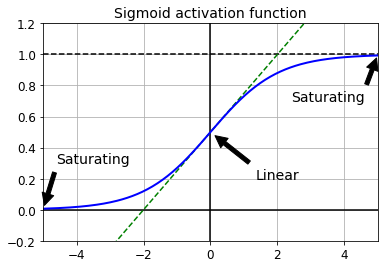

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])


plt.show()

Del código anterior note que se satura en los extremos (o entradas muy negativas o muy positivas dan valor de salida 0 ó 1 respetivamente), causando que no se actualicen los gradientes en backpropagation.

## Inicializaciones Xavier y He

In [4]:
import tensorflow as tf

In [5]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [6]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


En el código anterior buscamos entrenar una red neuronal utilizando MNIST dataset, más adelante se verá a detalle.

Glorot y Bengio explican que debe ser uniforme el propagar las señales (forward y backpropagation) sin explotar o desvanecerse (obvio) haciendo las varianzas de las capas y entradas idénticas (en forward) y las varianzas de los gradientes sean iguales (en back).  Lo más cercano a lo propuesto, pues es casi imposible lograrlo es inicializar aleatoriamente los pesos, también llamada [Xavier Initialization](https://keras.io/initializers/), en keras, que es un framework para redes neuronales tenemos glorot_normal y glorot_uniform.

**Esta inicialización funciona bien para regresión logística.**

El resultado de estas inicializaciones aceleran el entrenamiento, no es por nada una de las más utilizadas al realizar experimentos con redes neuronales.  Adicionalmente existen otras estrategias de inicialización como cuando se utiliza Tangente Hiperbólica y ReLU en funciones de activación.

En tensorflow por defecto la inicialización es Xavier a menos que se especifique otra (He, funciona bien con ReLU).

## Funciones de Activación No Saturadas

Como observamos parte de que las redes neuronales no aprendieran segun el paper de Glorot y Bengio era la mala escogencia de las funciones de activación y sus inicializadores.  Las funciones como ReLU no se saturan a grandes valores y son fáciles de computar.

ReLU tiene el problema (a pesar de que su comportamiento es bueno) que las neuronas mueren (probablemente la mitad de su red neuronal de 0 de salida), más cuando el LR (learning rate) es alto.  El 0 se debe a que a resultados negativos la función siempre da 0, para esto crearon una función alterna llamada leaky ReLU.

### Leaky ReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

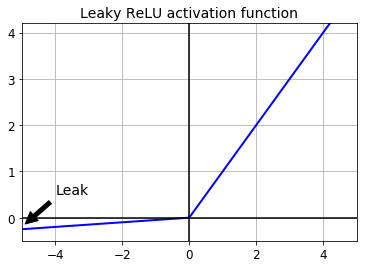

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])


plt.show()

Vemos entonces que la función de ReLU daría 0 para valores negativos, pero la Leaky ReLU tiene una pequeña pendiente a valores negativos.

In [9]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [10]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

Lo anterior podemos ver un resultado de [Leaky ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) en Tensorflow.  Algunos tmbién recomiendan un valor de alpha de 0.2 en vez de 0.01.  Otras funciones de activación proponen también cambiar el hiperparámetro alfa dinamicamente (RReLU) a medida que avanza el entrenamiento y otros de forma paramétrica PReLU, que hace alfa un hiperparámetro que se aprende durante el entrenamiento.

In [11]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [12]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [13]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [14]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [15]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [17]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

El código anterior entrena define una gráfica antes de entrenar la red neuronal basada en MNIST.

In [18]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [19]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [20]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.86 Validation accuracy: 0.9048
5 Batch accuracy: 0.94 Validation accuracy: 0.9496
10 Batch accuracy: 0.92 Validation accuracy: 0.9658
15 Batch accuracy: 0.94 Validation accuracy: 0.9712
20 Batch accuracy: 1.0 Validation accuracy: 0.9766
25 Batch accuracy: 1.0 Validation accuracy: 0.9776
30 Batch accuracy: 0.98 Validation accuracy: 0.978
35 Batch accuracy: 1.0 Validation accuracy: 0.9786


El código anterior muestra un entrenamiento del MNIST utilizando la inicialización propuesta por Glorot y Bengio utilizando leaky ReLU como función de activación.

### ELU

In [21]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

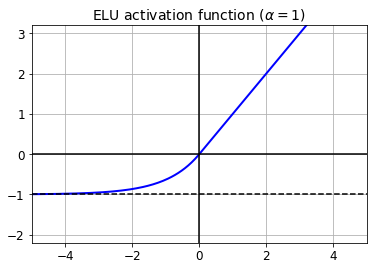

In [22]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])


plt.show()

El código anterior muestra la función de actiavción ELU, que según datos comprobados mejoras con creces el desempeño de ReLU reduciendo el tiempo de entrenamiento y desempeñandose mejor en el test set.

In [23]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [24]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

El código anterior implementa ELU en Tensorflow.

ELU a diferencia de ReLU tiene diferencias como:
- No se satura a varios valores negativos (para ELU hay una pequeña curva que el valor de alfa está cerca a 1, pero puede cambiarse)
- No permite que las neuronas 'mueran'
- La función es 'suave' incluso cuando z = 0.
- Converge rápidamente

Desventajas de ELU:
- Más costosa de computar que ReLU y sus variantes
- Tiempo de prueba de ELU es menor de la ReLU

### SELU

In [25]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [26]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

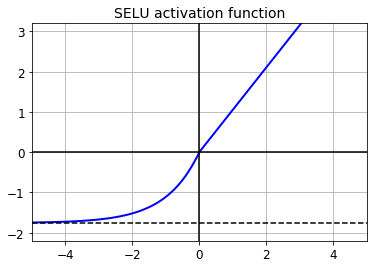

In [27]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])


plt.show()

Esta función de activación data del 2017 en el [paper](https://arxiv.org/pdf/1706.02515.pdf) de Günter Klambauer, Thomas Unterthiner y Andreas Mayr. 

Para este recomiendan si se usa SELU la función de inicialización de LeCun que sera auto normalizada manteniendo la misma varianza y medias durante entrenamiento resolviendo el problema de gradientes explotantes o desvanescientes, especialmente se recomienda esto en redes neuronales.

El problema es que SELU se rompe, no se puede unar ni regularizaciones L1 o L, dropout, max-norm, etc., pero funciona bien con CNNs secuenciales. Sin rombper auto-normalización, SELU funciona muy bien.

Por defecto, estos hiperparámetros de SELU son ajustados para que las salidas sean cercanas a 0 (hiperparámetros `scale` y `alpha`), y la desviación estándar cerca a 1.

In [28]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


In [29]:
def selu(z, scale=alpha_0_1, alpha=scale_0_1):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

Para usar Dropout con SELU debe utilizarse otra tipo de función `tf.contrib.nn.alpha_dropout()`.

In [30]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

Del código anterior creamos una gráfica de TF

In [31]:
means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final_selu.ckpt")

0 Batch accuracy: 0.94 Validation accuracy: 0.9388
5 Batch accuracy: 0.98 Validation accuracy: 0.9634
10 Batch accuracy: 1.0 Validation accuracy: 0.9694
15 Batch accuracy: 1.0 Validation accuracy: 0.9706
20 Batch accuracy: 1.0 Validation accuracy: 0.969
25 Batch accuracy: 1.0 Validation accuracy: 0.9692
30 Batch accuracy: 1.0 Validation accuracy: 0.971
35 Batch accuracy: 1.0 Validation accuracy: 0.9704


Entrenamos una red neuronal.

Antes debemos de escalar las entradas a 0 media y 1 de desviación estándar.

# Normalización del Batch

ELU y demás funciones al sufrir de saturación no cumplen a veces con regresar a actualizar los pesos.  Para esto se propuso una técnica llamada 'batch normalization' para alivianar los gradientes explotantes o desvanescientes y el cambio de la distribución cambie durante el training.

Consiste en antes de realizar la activación de cada capa centrar a 0 y normalizar entradas, ver [algoritmo](https://en.wikipedia.org/wiki/Batch_normalization).  Prácticamente necesita la media y desviación estándar del conjunto de mini batch antes de realizar una adecuación.

Se demostró que con varias funciones de activación (que tienen punto de saturación) mejoraba el training eficientemente y eran menos sensitivas a inicialización de pesos, se podían utilizar learning rates más altos.  Al momento de entrenamiento verémos que se vuelve más lento debido al cálculo que debe de hacer pero esto es normal.

In [33]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


In [34]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

La función de tensorflow .batch_normalization() hace el trabajo anteriormente mencionado de normalizr las entradas y centrar en cero.

El código anterior define un placeholer del training set ajustada en false para en el training por medio de batch normalization hacer el trabajo de normalizar y centrar cuando se pone en true, luego ubicamos redes totalmente conectadas y al final realizamos una normalización para luego usar la función de activación ELU, note que el hiperparámetro momentum viene dado por $v = v * momentum + v * (1 - momentum)$

En la figura inferior tomaremos la función `partial()` para no repetir los mismos parámetros una y otra vez.

In [35]:
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

In [36]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

El código anterior es lo mismo que el codigo que conversamos en el laboratorio pasado.

In [37]:
n_epochs = 20
batch_size = 200

In [38]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.8952
1 Validation accuracy: 0.9202
2 Validation accuracy: 0.9318
3 Validation accuracy: 0.9422
4 Validation accuracy: 0.9468
5 Validation accuracy: 0.954
6 Validation accuracy: 0.9568
7 Validation accuracy: 0.96
8 Validation accuracy: 0.962
9 Validation accuracy: 0.9638
10 Validation accuracy: 0.9662
11 Validation accuracy: 0.9682
12 Validation accuracy: 0.9672
13 Validation accuracy: 0.9696
14 Validation accuracy: 0.9706
15 Validation accuracy: 0.9704
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.9726
18 Validation accuracy: 0.9738
19 Validation accuracy: 0.9742


El código anterior es igual con algunas diferencias, por ejemplo, se hace True la sección que depende de batch normalization-  UPDATE_OPS es necesaria para cuando se da el uso de la función batch_normalization pues debe evaluar algunas alternativas en cada etapa.

Notará que no tiene la 'gran precision' mencionada, pero es debido a que para que mejore necesita:
- Entrenar por más tiempo
- Hacer la red neuronal más profunda

Se puede hacer la función de training dependiente de UPDATE_OPS como sigue:

```python
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(loss)
```

Así solo se evalua `training_op` durante entrenamiento, TensorFlow automáticamente corre el grupo en la sesión como sigue:

```python
sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
```

Además, note que la lista de variables entrenadas es más corta que la lista de variables globales. Esto se debe a que los promedios móviles no son variables de entrenamiento.  Si se desea utilizar una red neuronal pre-entrenada no se deben de tomar a la ligera el olvidar estas variables.

In [39]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [40]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

## Clipping del Gradiente

Preferiblemente se utiliza esta técnica para RNN (Recurrent Neural Networks) pero las personas prefieren batch normalization, ambas previenen gradientes explotantes.

In [53]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [54]:
learning_rate = 0.01

El código anterior solamente hace una red neuronal de varias capas ocultas sobre el MNIST dataset con LR = 0.01.

Para utilizar 'gradient clipping', se deben computar los gradientes y luego utilizar `clip_by_value()`, finalmente aplicarlo:

In [55]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

Más de lo mismo a nivel inferior...

In [56]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [57]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [58]:
n_epochs = 20
batch_size = 200

In [59]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.2878
1 Validation accuracy: 0.794
2 Validation accuracy: 0.88
3 Validation accuracy: 0.9062
4 Validation accuracy: 0.9162
5 Validation accuracy: 0.922
6 Validation accuracy: 0.9292
7 Validation accuracy: 0.9356
8 Validation accuracy: 0.9384
9 Validation accuracy: 0.9416
10 Validation accuracy: 0.9456
11 Validation accuracy: 0.9468
12 Validation accuracy: 0.9476
13 Validation accuracy: 0.9534
14 Validation accuracy: 0.9568
15 Validation accuracy: 0.9566
16 Validation accuracy: 0.9578
17 Validation accuracy: 0.959
18 Validation accuracy: 0.962
19 Validation accuracy: 0.9616


## Reutilizando Capas Pre-Entrenadas

Cuando se utiliza redes neuronales no se inicia de cero siempre, es buena costumbre utilizar una red neuronal que hizo una tarea similar y solamente reutilizar las capas infoeriores, esta técnica se llama 'transfer learning'.  Mejora el enmtrenamiento y también tardará menos.

Resumen:  En transfer learning solamente desbloqueamos la última capa de pesos y salida y mantenemos fijas las capas con pesos anteriores.

## Reusando un Modelo de TensorFlow

Primero importamos la gráfica con `import_meta_graph()`, carga la gráfica y la retorna en la variable `Saver`, la gráfica está salvada en este archivo `.meta`.

In [60]:
reset_graph()

In [61]:
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

Para ver las operaciones en la estructura de gráfica podemos observarla de esta manera.  Esto se hace cuando el modelo no está bien estructurado, pero existe la otra manera con tensorboard.

In [62]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

Como son muchas operacioens es más facil utilizar Tensorboard para visualizar la gráfica.  Nuevamente utilizaremos la función gráfica implementada en Jupyter.

In [63]:
import tensorflow as tf
import numpy as np
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32, width=800, height=600):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:{height}px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()), height=str(height))
  
    iframe = """
        <iframe seamless style="width:{width}px;height:{height}px;border:0" srcdoc="{code}"></iframe>
    """.format(code=code.replace('"', '&quot;'), width=width, height=str(height + 20))
    display(HTML(iframe))

In [65]:
show_graph(tf.get_default_graph())

Como ahora se visualiza las operaciones necesarias, puede utilizar las debidas funciones `get_operation_by_name()` o `get_tensor_by_name()` para adquirir las entradas, función de perdida y las ultimas capas.

In [66]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

En el codigo siguiente podemos compactar el uso de las variables para legibilidad, de esta manera se tienen funciones bien documentadas

In [67]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

Y para reutilizar el modelo simplemente se tiene:

In [68]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

Ahora se inicia la sesión, restaura el modelo y se continua con el entrenamiento.

In [69]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    # continue training the model...

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


Probamos nuevamente el training.

In [70]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


0 Validation accuracy: 0.9634
1 Validation accuracy: 0.9632
2 Validation accuracy: 0.9656
3 Validation accuracy: 0.9652
4 Validation accuracy: 0.9642
5 Validation accuracy: 0.9648
6 Validation accuracy: 0.9686
7 Validation accuracy: 0.9684
8 Validation accuracy: 0.9686
9 Validation accuracy: 0.9686
10 Validation accuracy: 0.9704
11 Validation accuracy: 0.9718
12 Validation accuracy: 0.9674
13 Validation accuracy: 0.97
14 Validation accuracy: 0.9708
15 Validation accuracy: 0.9722
16 Validation accuracy: 0.972
17 Validation accuracy: 0.971
18 Validation accuracy: 0.9712
19 Validation accuracy: 0.971


Si utilizamos `import_meta_graph()` es porque tenemos acceso a la gráfica.  Pero normalmente se requiere para transfer learning es tener las capas inferiores y solamente modificar las ultimas capas o construir nuevas capas, crear funciones de optimización, una nueva salida, etc.

In [71]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

saver = tf.train.Saver()

Y continuamos el entrenamiento:

In [72]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


0 Validation accuracy: 0.9644
1 Validation accuracy: 0.9632
2 Validation accuracy: 0.9654
3 Validation accuracy: 0.9656
4 Validation accuracy: 0.9644
5 Validation accuracy: 0.965
6 Validation accuracy: 0.9686
7 Validation accuracy: 0.9686
8 Validation accuracy: 0.9686
9 Validation accuracy: 0.9684
10 Validation accuracy: 0.9702
11 Validation accuracy: 0.9716
12 Validation accuracy: 0.9672
13 Validation accuracy: 0.97
14 Validation accuracy: 0.9706
15 Validation accuracy: 0.9722
16 Validation accuracy: 0.9716
17 Validation accuracy: 0.971
18 Validation accuracy: 0.9712
19 Validation accuracy: 0.9716


En general, buscamos utilizar las capas que queremos reentrenar.  Si se utiliza`import_meta_graph()` cargará toda la gráfica, uno simplemente debe ignorar las partes que no se necesita.  Por ejemplo añadimos en el código inferior una cuarta capa oculta al borde de la tercera capa pre entrenada (ignorando la 4ta capa).  Construimos una nueva capa de salida y una función de pérdida además de un nuevo optimizador para minimizar.  También necesitamos otro 'saver' para la nueva gráfica (contiene la grafica vieja y las nuevas operaciones), y sus inicializaciones de las nuevas variables:

In [73]:
reset_graph()

n_hidden4 = 20  # new layer
n_outputs = 10  # new layer

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden3/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

Y entrenamos este nuevo modelo:

In [74]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = new_saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


0 Validation accuracy: 0.9186
1 Validation accuracy: 0.9392
2 Validation accuracy: 0.9486
3 Validation accuracy: 0.9528
4 Validation accuracy: 0.9554
5 Validation accuracy: 0.9556
6 Validation accuracy: 0.9574
7 Validation accuracy: 0.9612
8 Validation accuracy: 0.9612
9 Validation accuracy: 0.9644
10 Validation accuracy: 0.965
11 Validation accuracy: 0.9658
12 Validation accuracy: 0.964
13 Validation accuracy: 0.9672
14 Validation accuracy: 0.969
15 Validation accuracy: 0.9682
16 Validation accuracy: 0.9702
17 Validation accuracy: 0.9678
18 Validation accuracy: 0.9696
19 Validation accuracy: 0.9698


Si tiene acceso al código de python que construyó la gráfica original, puede reutilizar las partes que necesitan y retirar el resto.

In [75]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

Cabe destacar quie se necesita construir un 'Saver' para cargar y otro 'Saver' para guardar, de lo contrario las gráficas no coincidirán, el último es del modelo re entrenado.

In [76]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):                                            # not shown in the book
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})        # not shown
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})     # not shown
        print(epoch, "Validation accuracy:", accuracy_val)                   # not shown

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


0 Validation accuracy: 0.9018
1 Validation accuracy: 0.9336
2 Validation accuracy: 0.9428
3 Validation accuracy: 0.947
4 Validation accuracy: 0.9518
5 Validation accuracy: 0.953
6 Validation accuracy: 0.9558
7 Validation accuracy: 0.9594
8 Validation accuracy: 0.9584
9 Validation accuracy: 0.9606
10 Validation accuracy: 0.9626
11 Validation accuracy: 0.962
12 Validation accuracy: 0.9636
13 Validation accuracy: 0.966
14 Validation accuracy: 0.966
15 Validation accuracy: 0.966
16 Validation accuracy: 0.9672
17 Validation accuracy: 0.9676
18 Validation accuracy: 0.9682
19 Validation accuracy: 0.968


## Reutilizando Modelos de Otros 'Frameworks'

Si no utiliza Tensorflow, entonces para cada variable a utilizar, si es otro framework com PyTorch o Theano se debe cargar las variables apropiadas, esto es un poco tedioso.  Debajo se muestra la manera.  Primero se ubica los operadores de inicialización y luego vemos la segunda entrada, la cual corresponde a valor de inicialización. Cuando se corre el inicializador luego reemplazamos los valores de inicialización con un `feed_dict`

In [77]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

In [78]:
original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the assignment nodes for the hidden1 variables
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))  # not shown in the book

[[ 61.  83. 105.]]


Otra alternativa es crear una asignación dedicada a los nodos y placeholders.  Esta es tiene más ayuda en salida y es menos eficiente, pero es más explícita.

In [79]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the variables of layer hidden1
with tf.variable_scope("", default_name="", reuse=True):  # root scope
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")

# Create dedicated placeholders and assignment nodes
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]


También nótese que se puede tener la variable `get_collection()` y especificar `scope`:

In [80]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

O podemos utilizar el método de la gráfica `get_tensor_by_name()`

In [81]:
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [82]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

### Congelando las capas inferiores

Como las caps inferiores de la red neuronal detectan características de bajo nivel en las figuras, podemos reutilizar estas capas como son.  En general es una buena idea 'congelar' los pesos cuando se entrena una nueva red neuronal para que sea más fácil de entrenar esta última capa.

La siguiente es la primera manera, es solamente dando el nombre de las variables a entrenar, detallaremos en la sección que se utiliza más adelante.

In [83]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [84]:
with tf.name_scope("train"):                                         # not shown in the book
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)     # not shown
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)

En el código anterior utilizamos las variables de entrenamiento que se extraen de las capas 3 y 4 en la capa de salida.  Esto deja las variables en las capas ocultas 1 y 2.

In [85]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


0 Validation accuracy: 0.8954
1 Validation accuracy: 0.93
2 Validation accuracy: 0.9404
3 Validation accuracy: 0.9444
4 Validation accuracy: 0.9478
5 Validation accuracy: 0.9508
6 Validation accuracy: 0.9508
7 Validation accuracy: 0.9534
8 Validation accuracy: 0.9552
9 Validation accuracy: 0.9564
10 Validation accuracy: 0.956
11 Validation accuracy: 0.957
12 Validation accuracy: 0.9572
13 Validation accuracy: 0.9578
14 Validation accuracy: 0.959
15 Validation accuracy: 0.9578
16 Validation accuracy: 0.9576
17 Validation accuracy: 0.9602
18 Validation accuracy: 0.959
19 Validation accuracy: 0.9602


In [86]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [87]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

Del código anterior podemos ver otra opción la cual es deteniendo o manteniendo los pesos en las capas 1 y 2 y reentrenando las capas 3 y 4 que son las finales.

Las siguientes lineas son más de lo mismo.

In [88]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

El código de entrenamiento es igual al anterior.

In [89]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


0 Validation accuracy: 0.902
1 Validation accuracy: 0.931
2 Validation accuracy: 0.943
3 Validation accuracy: 0.948
4 Validation accuracy: 0.9514
5 Validation accuracy: 0.9524
6 Validation accuracy: 0.9522
7 Validation accuracy: 0.9554
8 Validation accuracy: 0.9552
9 Validation accuracy: 0.9558
10 Validation accuracy: 0.957
11 Validation accuracy: 0.9554
12 Validation accuracy: 0.957
13 Validation accuracy: 0.9578
14 Validation accuracy: 0.9582
15 Validation accuracy: 0.957
16 Validation accuracy: 0.9566
17 Validation accuracy: 0.9576
18 Validation accuracy: 0.9592
19 Validation accuracy: 0.9578


### Almacenamiento en Caché de Capas Congeladas

Como las capas inferiores no cambiarán es posible almacenar las salidas de estas capas congeladas en cada instancia, de esta manera acelerará el training pues solamente se visitarán estas capas una vez cada epoch.

In [90]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen & cached
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [91]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [92]:
import numpy as np

n_batches = len(X_train) // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: X_train})
    h2_cache_valid = sess.run(hidden2, feed_dict={X: X_valid}) # not shown in the book

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(X_train))
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})

        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid, # not shown
                                                y: y_valid})             # not shown
        print(epoch, "Validation accuracy:", accuracy_val)               # not shown

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


0 Validation accuracy: 0.902
1 Validation accuracy: 0.931
2 Validation accuracy: 0.943
3 Validation accuracy: 0.948
4 Validation accuracy: 0.9514
5 Validation accuracy: 0.9524
6 Validation accuracy: 0.9522
7 Validation accuracy: 0.9554
8 Validation accuracy: 0.9552
9 Validation accuracy: 0.9558
10 Validation accuracy: 0.957
11 Validation accuracy: 0.9554
12 Validation accuracy: 0.957
13 Validation accuracy: 0.9578
14 Validation accuracy: 0.9582
15 Validation accuracy: 0.957
16 Validation accuracy: 0.9566
17 Validation accuracy: 0.9576
18 Validation accuracy: 0.9592
19 Validation accuracy: 0.9578


# Mejores Optimizadores (más rápidos)

Entrenar una red neuronal puede ser muy extenso y cansa, consume tiempo.  Hasta el momento se habló de como acelerar el entranamiento llegando a mejores soluciones como inicializar los pesos y buenas funcioens de activación, usar batch normalization y partes de una red neuronal para pre entrenar.  Existen otros optimizadores que se usan para acelerar el training.

## Optimización por Momentum

Es como tener un balón y dejarlo caer en una pendiente, inicialmente irá lento pero luego tomará velocidad gradual.  Esta técnica la propuso Boris Polyak en 1964 a diferencia de gradiente descendiente que toma saltos regulares hasta llegar hasta el fondo.

Recuerde que el gradiente actualiza los pesos de la función de costo $J(\theta)$ utilizando también el $\eta$.  [Momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum) opera por medio de donde quedaron los gradientes, y actualiza los pesos añadiendo el vecto de momentum. Además del Learning Rate que está en la ecuación también posee un parametro alfa (a veces también denotado por beta).

El gradiente permaneces constante en la velocidad terminal (tamaño máximo de las actualizacioens de pesos).  Regla general es utilizar un $\eta$ un valor dependiente de $\beta$, así $\frac{1}{1-\beta}$.  Este correrá más rápido que el gradiente descendiente y también escapará de plateaux y de la óptima local.

In [93]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

Una cosa negativa de momentum es que utiliza un nuevo hiperparámetro, pero un valor de 0.9 es recomendado con buenos resultados.

## Gradiente Acelerado de Nesterov

Yuri Nesterov en 1983 propone algo un poco mejor que la implementación solitaria de momentum que era medir el gradiente un poco despues de él, es decir es medido en $\theta + \beta m$ en vez de $\theta$.

Y funciona bien, es mejor utilizar esta medida del gradiente en su posición siguiente, siempre termina cercano al óptimo local permitioendo a las menores osicilaciones del algoritmo y converger rápidamente.

El NAG (Nesterov Accelerated Gradient) se puede utilizar como sigue.

In [94]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)

## AdaGrad

Ahora repasaremos lo que hace este optimizador.  A diferencia de gradiente descendiente que baja la pendiente más empinada este algoritmo detecta y escala el vector de gradiente a traves de las dimensiones más empinadas. [Adagrad](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#AdaGrad) acumula el cuadrado de los gradientes en un vector $s$ acumuklando la derivada parcial de la función de costo $\theta_i$, esta se volverá más extensa en cada iteración hasta llegar al mínimo global.

La siguiente parte del algoritmo se parece a gradiente descendiente pero el vector se reduce a un factor de $\sqrt{s + \epsilon}$, donde $\epsilon$ es un valor bajo cercano a cero (10^10 p.e.).  En resumen hace decaer el learning rate pero más rápido y en pendientes más finas.  También llamado 'adaptative learning rate' y requiere menos ajuste porque solo es el parámetro $\eta$.

A pesar que lo hace relativamente bien, tiene problemas que se detiene tempranamente con redes neuronales debido a que escala mucho antes de llegar al minimo global óptimo.  EVITAR USAR ADAGRAD CON REDES NEURONALES!

In [95]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

## RMSProp

AdaGrad llega al óptimo global como se dijo, pero en raras ocasiones, Este algoritmo fija esto acumulando solamente gradientes de las iteracioens recientes (opuesto a todos los gradientes desde el inicio de entrenamiento), simplemente utiliza una decaída exponencial.

El hiperparámetro $\beta$ normalmente con 0.89 da buenos resultados.  Preferiblemente utilizar este en ves de AdaGrad.

El algoritmo se puede encontrar en [esta dirección](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp)

In [96]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10)

## Adam Optimization

[Este](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam) algoritmo de optimización combina las ideas de momentum y RMSProp manteniendo los gradientes pasados exponencialmente decayendo y el decaimiento al cuadrado de los gradientes pasados.

Favor compare las ecuaciones de RMSProp y Momentum para que note su similaridad.

La desventaja es que se añaden dos hiperparámetros $\beta_1$ y $\beta_2$ pero que inicializados a 0.9 y 0.999 dan buenos resultados.  De esta manera su inicialización se puede hacer sencilla para $\eta$ 0.001

In [97]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

Las optimizaciones anteriores confian en las derivadas parciales de primer orden (llamados también Jacobianos).  Las derivadas parciales de segundo orden o Hesianos son algoritmos muy óptimos sin embargo son difíciles de aplicar para redes neuronales porque hay $n^2$ Hesianos por cada salida.  Son difíciles de computar y no caben en la memoria de las computadoras actuales, además de ser lentos.

## Agendamiento del Learning Rate

Es difícil encontrar un buen learning rate.  Si es muy alto puede diverger, si es miy bajo demorará mucho el entrenamiento, pero encontrará el óptimo local o el global.  Si se mantiene ligeramente alto irá descendiendo pero saltando sobre el óptimo global (fue para esto que recomendamos utilizar algoritmos adaptativos como RMSProp o Adam).

La otra opción es interrumpir el entrenamiento que viaje a una solución subóptima.

Puede encontrar un learning rate durante algunos epochs, pero el ideal será el que converja a la solución más rápidamente.

Si pudiesemos iniciar con un LR alto y luego disminuirlo iríamos más rápido.  Ls estrategias más comunes son:
- Un learning rate dividido en pedazos:  Es decir, por ejemplo, primero en 0.1 luego en 0.001 despues de 50 epochs, funciona bien, pero tendríamos que saber en donde ir dividiendo.
- Scheduling de desempeño: midiendo el error cada N pasos (como en early stoping) y reducir el LR en un factor lambda
- Scheduling exponencial: simplemente cambiar la función del LR a $\eta(t) = \eta_0 * 10^{t/r}$.  Funciona bien pero requiere de estas dos variables $\eta_0$ y $r$.
- Scheduling de Potencias:  Ajustar el learning rate a un valor exponencial en la función $\eta(t) = \eta_0 (1+t/r)^{-c}$. C es tipicamente ajustado a 1 para que el LR baje finamente.

En el 2013 un paper de Andrew Senior evaluó todos los métodos y dedujo que el exponencial y de scheduling teian buen desempeño pero favorecia al exponencial que era más facil de implementar.

In [98]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [99]:
with tf.name_scope("train"):       # not shown in the book
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

Del codigo anetrior vemos que TF tiene como realizar este con .exponential_decay,  luego creamos un optimizador de momentum sobre este LR, el algoritmo optimizará para $\eta = 0.1$ y $r = 10000$.

In [100]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [101]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9614
1 Validation accuracy: 0.9712
2 Validation accuracy: 0.9786
3 Validation accuracy: 0.9794
4 Validation accuracy: 0.9822


# Previniendo Overfitting a Través de Regularización

Normalmente hemos visto que estas redes neuronales tienen muchos hiperparámetros qeu ajustar, a veces millones.  Esto a veces tiende a que el dataset y su entrenamiento recaigan en overfitting.

Veremos algunos de los principales métodos para reducir overfitting.

## Parada Temprana

Una solución sencilal es interrumpir el entrenamiento antes de que el validation set empiece a caer, luego se salva el modelo en ese punto y se detiene el entrenamiento.  Generalmente es una de las primeras cosas que se realiza pero también se puede realizar cosas mejores con otras técnicas de regularización.

## Regularización $\ell_1$ y $\ell_2$

Simplemente en tensorflow se debe añadir el termin de regularización en la función de costo, para cada caso de los pesos se debería implementar una regularización de la capa de pesos W1, W2 hsta Wn.

In [102]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

Next, we get a handle on the layer weights, and we compute the total loss, which is equal to the sum of the usual cross entropy loss and the $\ell_1$ loss (i.e., the absolute values of the weights):

In [103]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001 # l1 regularization hyperparameter

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")

El código anterior implementa a mano la regularización solamente para una red neuronal de dos etapas

Lo siguiente es lo de siempre

In [104]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [105]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.831
1 Validation accuracy: 0.871
2 Validation accuracy: 0.8838
3 Validation accuracy: 0.8934
4 Validation accuracy: 0.8966
5 Validation accuracy: 0.8988
6 Validation accuracy: 0.9016
7 Validation accuracy: 0.9044
8 Validation accuracy: 0.9058
9 Validation accuracy: 0.906
10 Validation accuracy: 0.9068
11 Validation accuracy: 0.9054
12 Validation accuracy: 0.907
13 Validation accuracy: 0.9084
14 Validation accuracy: 0.9088
15 Validation accuracy: 0.9064
16 Validation accuracy: 0.9066
17 Validation accuracy: 0.9066
18 Validation accuracy: 0.9066
19 Validation accuracy: 0.9052


Alternativamente podemos pasar una función de regularización a `tf.layers.dense()`, la cual utilizará para crear operaciones que computarán funciones de perdida de regularización, y esta añade estas operacioenes a la colección de pérdidas de regularización.

El código inferior es lo mismo que el anterior.

In [106]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

También pdoemos utilizar `partial()` para esquivar los mismos argumentos una y otra vez, ahora también utilizaremos la función `kernel_regularizer` como argumento:

In [107]:
scale = 0.001

In [108]:
my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Seguido debemos añadir las pérdidas de regularización a la pérdida de base.

In [110]:
with tf.name_scope("loss"):                                     # not shown in the book
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  # not shown
        labels=y, logits=logits)                                # not shown
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   # not shown
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

Lo demás es como lo usual:

In [111]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [112]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.8274
1 Validation accuracy: 0.8766
2 Validation accuracy: 0.8952
3 Validation accuracy: 0.9016
4 Validation accuracy: 0.9084
5 Validation accuracy: 0.9096
6 Validation accuracy: 0.9124
7 Validation accuracy: 0.9154
8 Validation accuracy: 0.9178
9 Validation accuracy: 0.919
10 Validation accuracy: 0.92
11 Validation accuracy: 0.9224
12 Validation accuracy: 0.9212
13 Validation accuracy: 0.9228
14 Validation accuracy: 0.9224
15 Validation accuracy: 0.9216
16 Validation accuracy: 0.9218
17 Validation accuracy: 0.9228
18 Validation accuracy: 0.9216
19 Validation accuracy: 0.9214


## Dropout

Esta técnica es comun en redes neuronals, propuesta por G. Hinton en el 2012 y detallada en un paper de Nitish Srivastva ha sido probada dar buenos resultados (generalmente altos).  Añadir dropout puede aumentar 1-2% de precisión.

El algoritmo es simple, realiza una discriminación de neuronas basadas en su probabilida de salida, aquellas que no cumplan serán 'apagadas' o sea ignoradas del entrenamiento.

In [113]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [114]:
training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

Instructions for updating:
Use keras.layers.dropout instead.


Instructions for updating:
Use keras.layers.dropout instead.


In [115]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [116]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9246
1 Validation accuracy: 0.9454
2 Validation accuracy: 0.9474
3 Validation accuracy: 0.9524
4 Validation accuracy: 0.9602
5 Validation accuracy: 0.9644
6 Validation accuracy: 0.961
7 Validation accuracy: 0.9666
8 Validation accuracy: 0.966
9 Validation accuracy: 0.9678
10 Validation accuracy: 0.9694
11 Validation accuracy: 0.9674
12 Validation accuracy: 0.9704
13 Validation accuracy: 0.9692
14 Validation accuracy: 0.9726
15 Validation accuracy: 0.9712
16 Validation accuracy: 0.9746
17 Validation accuracy: 0.9724
18 Validation accuracy: 0.9732
19 Validation accuracy: 0.9752


## Max norm

Esta es [otra técnica](https://en.wikipedia.org/wiki/Norm_(mathematics)#Maximum_norm_(special_case_of:_infinity_norm,_uniform_norm,_or_supremum_norm)) de regularización.

Para cada neurona, en contraste de los pesos en donde $||w||_2 \leq r$ se implementa por medio de actualización de ($w = w*r/||w||_2$)

Tensorflow no tiene esta implementada pero no es difícil de realizar.  Debajo se muestran los pasos para implementar este tipo de normalización.

In [117]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

A continuación, controlamos el peso de la primera capa oculta y creemos una operación que calcule los pesos recortados utilizando la función `clip_by_norm ()`. Luego creamos una operación de asignación para asignar los pesos recortados a la variable de pesos:

In [118]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

Lo haremos también para la segunda capa oculta

In [119]:
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

Añadimos un inicializador y un Saver:

In [120]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Y ahora podemos entrenar al modelo. Es más o menos lo habitual, excepto que justo después de ejecutar `training_op`, ejecutamos las operaciones` clip_weights` y `clip_weights2`:

In [121]:
n_epochs = 20
batch_size = 50

In [122]:
with tf.Session() as sess:                                              # not shown in the book
    init.run()                                                          # not shown
    for epoch in range(n_epochs):                                       # not shown
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()                                        # not shown
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})   # not shown
        print(epoch, "Validation accuracy:", acc_valid)                 # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")               # not shown

0 Validation accuracy: 0.9566
1 Validation accuracy: 0.9704
2 Validation accuracy: 0.9716
3 Validation accuracy: 0.9766
4 Validation accuracy: 0.9772
5 Validation accuracy: 0.9776
6 Validation accuracy: 0.9818
7 Validation accuracy: 0.9806
8 Validation accuracy: 0.9798
9 Validation accuracy: 0.982
10 Validation accuracy: 0.9824
11 Validation accuracy: 0.9846
12 Validation accuracy: 0.9824
13 Validation accuracy: 0.9838
14 Validation accuracy: 0.9844
15 Validation accuracy: 0.985
16 Validation accuracy: 0.9838
17 Validation accuracy: 0.9844
18 Validation accuracy: 0.9842
19 Validation accuracy: 0.9846


La implementación anterior es sencilla y funciona bien, pero es un poco desordenada. Un mejor enfoque es definir una función `max_norm_regularizer ()`:

In [123]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

Entonces puede llamar a esta función para obtener un normalizador de norma máxima (con el umbral que desee). Cuando crea una capa oculta, puede pasar este regularizador al argumento `kernel_regularizer`:

In [124]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [125]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [126]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

El entrenamiento es el habitual, excepto que debe ejecutar las operaciones de recorte de pesos después de cada operación de entrenamiento:

In [127]:
n_epochs = 20
batch_size = 50

In [128]:
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) # not shown
        print(epoch, "Validation accuracy:", acc_valid)               # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")             # not shown

0 Validation accuracy: 0.9558
1 Validation accuracy: 0.97
2 Validation accuracy: 0.9732
3 Validation accuracy: 0.9758
4 Validation accuracy: 0.9764
5 Validation accuracy: 0.979
6 Validation accuracy: 0.98
7 Validation accuracy: 0.9812
8 Validation accuracy: 0.9808
9 Validation accuracy: 0.981
10 Validation accuracy: 0.982
11 Validation accuracy: 0.9816
12 Validation accuracy: 0.982
13 Validation accuracy: 0.9824
14 Validation accuracy: 0.9826
15 Validation accuracy: 0.9822
16 Validation accuracy: 0.982
17 Validation accuracy: 0.9824
18 Validation accuracy: 0.9822
19 Validation accuracy: 0.982


# Laboratorio

Parte 1 - Deep Learning - 50%
- Construir una red neuronal con 5 capas ocultas de 100 neuronas cada 1 - 10%
- He y ELU como funciones inicialización y de activación - 5%
- Use un optimizador basado en adam y early stop con MNIST -5%
- Ajuste los hiperparámetros usando cross validation y trate de llegar a una precisión alt - 10%
- Utilice ahora batch normalization y deduzca cual fue mejor y porqué - 10%
- Añada dropout para prevenir overfitting - 10%

Parte 2 - Transfer Learning - 50%
- Crear una red neuronal que reuse el modelo de las capas ocultas anteriores (congele todas menos las 2 ultimas capas), reemplace la función de activación por softmax - 25%
- Haga transfer learning sobre el modelo guardado anteriormente para entrenar solo los números 5 al 9 - 25%.